## GTラベル間の混同について

- 専門家間での表の割れ具合を調査する。
- low-qualityとhigh-qualityでの傾向の違いをみる

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
from seaborn import heatmap

from src.constant import LABELS
from src.preprocess import process_label

plt.style.use("tableau-colorblind10")

import matplotlib.pyplot as plt

from src.error_analysis import calc_conditional_prob

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"gt_{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)
display(metadata.head())

eeg_id,gt_seizure_prob,gt_lpd_prob,gt_gpd_prob,gt_lrda_prob,gt_grda_prob,gt_other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
643036156,0.692308,0.0,0.307692,0.0,0.0,0.0,0.464286
2437858065,0.965517,0.034483,0.0,0.0,0.0,0.0,0.115079
299439111,0.0,0.46,0.0,0.465,0.0,0.075,0.396825
3675691893,0.807692,0.192308,0.0,0.0,0.0,0.0,0.132653
315795391,0.6875,0.28125,0.0,0.03125,0.0,0.0,0.163265


In [3]:
low_quality = metadata.filter(pl.col("weight") < 0.3).filter(pl.col("weight") > 0.1)
high_quality = metadata.filter(pl.col("weight") >= 0.3)

In [4]:
def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


pred_df = pl.read_parquet(
    "../data/pseudo_label/v5_eeg_24ep_cutmix/train_pseudo_label.pqt"
)
pred_df = (
    pred_df.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
).drop("weight", *[f"pl_{label}_vote" for label in LABELS], "pl_vote")
pred_high_quality = pred_df.join(
    high_quality, on="eeg_id", how="inner"
)
pred_low_quality = pred_df.join(low_quality, on="eeg_id", how="inner")
pred_high_quality.head()

eeg_id,pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob,gt_seizure_prob,gt_lpd_prob,gt_gpd_prob,gt_lrda_prob,gt_grda_prob,gt_other_prob,weight
i64,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
8027281,0.012755,0.562664,0.040462,0.060474,0.037525,0.286121,0.0,0.785714,0.0,0.142857,0.0,0.071429,0.5
10617205,0.005198,0.00302,0.005925,0.018033,0.486275,0.481549,0.0,0.0,0.0,0.0,0.416667,0.583333,0.428571
14623517,0.461269,0.022835,0.468381,0.001975,0.01193,0.033611,0.533333,0.0,0.4,0.0,0.0,0.066667,0.535714
15073201,0.017624,0.013983,0.035983,0.013213,0.056928,0.862269,0.0,0.0,0.058824,0.0,0.058824,0.882353,0.607143
17311157,0.00774,0.00523,0.021252,0.015932,0.254057,0.695789,0.0,0.0,0.0,0.0,0.153846,0.846154,0.464286


## 条件付き確率の定義

条件付き確率P(i | j)は、クラスi-j間での「専門家の混同しやすさ」を表していると考えられる。

基本的な考え方:

1. クラスのペア(i, j)に対して、両者のGT確率の積を計算して全サンプルで平均を取ることで全確率を求める。
2. 1で計算した全確率を周辺確率で割って正規化することで、条件付き確率P(i | j)を求める

厳密な定義:

$$
P(y_\text{pred} = j | y_\text{GT} = i) := \frac{P(y_\text{GT} = i, y_\text{pred} = j)}{P_{y_\text{GT}}(i)} \\\\
P_{y_\text{GT}}(i) := \sum_j P(y_\text{GT} = i, y_\text{pred} = j)
$$

$$
P(y_\text{GT} = i | y_\text{pred} = j) := \frac{P(y_\text{GT} = i, y_\text{pred} = j)}{P_{y_\text{pred}}(j)} \\\\
P_{y_\text{pred}}(j) := \sum_i P(y_\text{GT} = i, y_\text{pred} = j)
$$

## GTにおける専門家の表の割れ具合

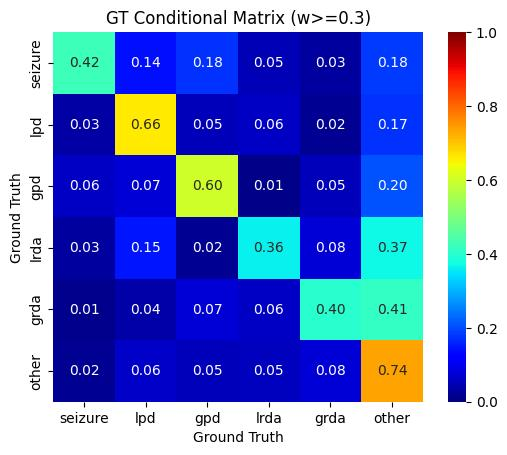

In [5]:
gts_high_quality = pred_high_quality.select(
    *[f"gt_{label}_prob" for label in LABELS]
).to_numpy()
preds_high_quality = pred_high_quality.select(
    *[f"pl_{label}_prob" for label in LABELS]
).to_numpy()

_, ax = plt.subplots()
confusion_high_quality = calc_conditional_prob(gts_high_quality, gts_high_quality, norm_axis=1)
heatmap(
    confusion_high_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="Ground Truth", ylabel="Ground Truth", title="GT Conditional Matrix (w>=0.3)"
)
plt.show()

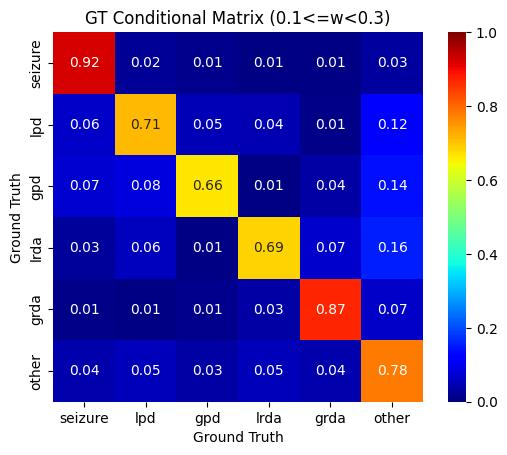

In [9]:
gts_low_quality = pred_low_quality.select(
    *[f"gt_{label}_prob" for label in LABELS]
).to_numpy()
preds_low_quality = pred_low_quality.select(
    *[f"pl_{label}_prob" for label in LABELS]
).to_numpy()


_, ax = plt.subplots()
confusion_low_quality = calc_conditional_prob(gts_low_quality, gts_low_quality, norm_axis=1)
heatmap(
    confusion_low_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="Ground Truth", ylabel="Ground Truth", title="GT Conditional Matrix (0.1<=w<0.3)"
)
plt.show()

## モデルの予測における票の割れ具合

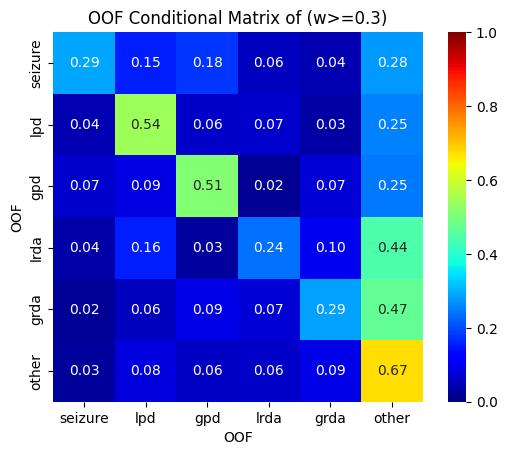

In [7]:
_, ax = plt.subplots()
confusion_preds_high_quality = calc_conditional_prob(preds_high_quality, preds_high_quality, norm_axis=1)
heatmap(
    confusion_preds_high_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="OOF", ylabel="OOF", title="OOF Conditional Matrix of (w>=0.3)"
)
plt.show()

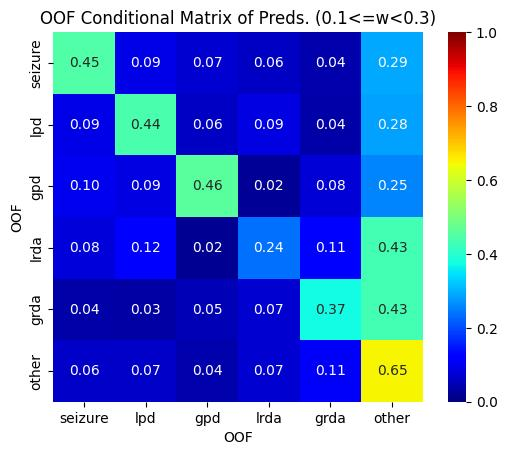

In [10]:
_, ax = plt.subplots()
confusion_preds_low_quality = calc_conditional_prob(preds_low_quality, preds_low_quality, norm_axis=1)
heatmap(
    confusion_preds_low_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="OOF", ylabel="OOF", title="OOF Conditional Matrix of Preds. (0.1<=w<0.3)"
)
plt.show()